In [30]:
!pip install roboflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.9/69.9 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 5.9 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.9.0.80
    Uninstalling opencv-python-headless-4.9.0.80:
      Successfully uninstalled opencv-python-headless-4.9.0.80
  Attempting uninstall: idna
    Found existing installation: idna 3.6
    Uninstalling idna-3.6:
      Successfully uninstalled idna-3.6
  Attempting uninstall: cycler
    Found existing installation: cycler

In [31]:
from roboflow import Roboflow
rf = Roboflow(api_key="2NBbupbg2nhidokX1UR0")
project = rf.workspace("study-jzyvf").project("metro-detection")
dataset = project.version(3).download("coco-segmentation")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Metro-Detection-3 in coco-segmentation:: 100%|██████████| 644/644 [00:00<00:00, 1429.23it/s]


In [32]:
!pip install pycocotools

In [33]:
!nvidia-smi

Sat Jan 20 09:54:17 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   76C    P0              34W /  70W |    349MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [34]:
IMAGE_HEIGHT, IMAGE_WIDTH = 1280, 768

In [35]:
def extend_image(img, channels=None):
    height, width = img.shape[0], img.shape[1]
    delta = IMAGE_WIDTH - width
    if channels:
        padding = np.zeros((height, int(delta / 2), channels), np.uint8)
    else:
        padding = np.zeros((height, int(delta / 2)), np.uint8)
    img = np.concatenate((padding, img, padding), axis=1)
    return img

In [36]:
import json
from pycocotools.coco import COCO
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Загрузите аннотации COCO JSON
coco_annotations_path = "/content/Metro-Detection-3/train/_annotations.coco.json"
coco = COCO(coco_annotations_path)

# Получите идентификаторы изображений с сегментацией
image_ids = coco.getImgIds(imgIds=coco.getImgIds())

# Задайте путь к папке с изображениями
images_folder_path = "/content/Metro-Detection-3/train"

images = []
masks = []

# Загрузите изображения и маски сегментации
for img_id in image_ids:
    img_info = coco.loadImgs(ids=img_id)[0]
    image_path = f"{images_folder_path}/{img_info['file_name']}"
    image = plt.imread(image_path)

    ann_ids = coco.getAnnIds(imgIds=img_info['id'])
    annotations = coco.loadAnns(ann_ids)

    # Создайте пустую маску
    mask = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)

    # Добавьте маски объектов на изображение
    for ann in annotations:
        coco_mask = coco.annToMask(ann)
        mask = np.maximum(mask, coco_mask * ann['category_id'])

    image = extend_image(image, 3)
    mask = extend_image(mask)

    images.append(image)
    masks.append(mask)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


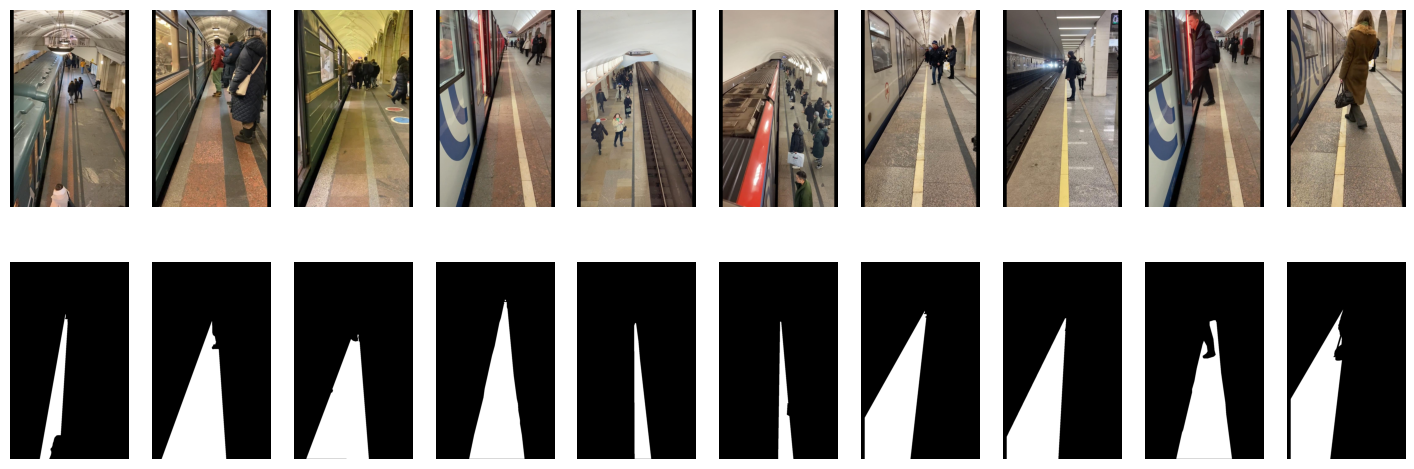

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 6))
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.axis("off")
    plt.imshow(images[i])

    plt.subplot(2, 10, i+11)
    plt.axis("off")
    plt.imshow(masks[i], cmap='gray')

plt.show()

In [38]:
DATA_SIZE = 640

In [39]:
ix = np.random.choice(len(images), DATA_SIZE, False)
tr, val, ts = np.split(ix, [int(0.8 * DATA_SIZE), int(0.9 * DATA_SIZE)])

In [40]:
print(len(tr), len(val), len(ts))

512 64 64


In [41]:
images = np.array(images)
masks = np.array(masks)

In [42]:
from torch.utils.data import DataLoader
batch_size = 3
data_tr = DataLoader(list(zip(np.rollaxis(images[tr], 3, 1), masks[tr, np.newaxis])),
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(images[val], 3, 1), masks[val, np.newaxis])),
                      batch_size=batch_size, shuffle=False)
data_ts = DataLoader(list(zip(np.rollaxis(images[ts], 3, 1), masks[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=False)

In [43]:
import torch
import torch.nn  as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

In [44]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [45]:
loss_history = {}
score_history = {}
models = {}

results = [loss_history, score_history, models]

for d in results:
    d['SegNet'] = {}
    d['UNet'] = {}

In [46]:
def handle_train_results(loss_hist, score_hist, average_time, model, architecture_name, criterion_name):
    loss_history[architecture_name][criterion_name] = loss_hist
    score_history[architecture_name][criterion_name] = score_hist
    models[architecture_name][criterion_name] = model

In [47]:
import gc

class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)  # 256 -> 128
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.pool1 =  nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.pool2 =  nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.bottleneck_pool = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

        self.boottleneck_upsample = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.dec_bottleneck = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        # decoder (upsampling)
        self.upsample0 =  nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        self.upsample1 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.upsample2 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.upsample3 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 1, kernel_size=3, padding=1),
        )

    def forward(self, x):
        # encoder
        x = x.float()
        e0 = self.enc_conv0(x)
        x, indices0 = self.pool0(e0)
        e1 = self.enc_conv1(x)
        x, indices1 = self.pool1(e1)
        e2 = self.enc_conv2(x)
        x, indices2 = self.pool2(e2)
        e3 = self.enc_conv3(x)
        x, indices3 = self.pool3(e3)

        gc.collect()

        # bottleneck
        b = self.bottleneck_conv(x)
        x, bottleneck_indices = self.bottleneck_pool(b)
        x = self.boottleneck_upsample(x, bottleneck_indices)
        dec_b = self.dec_bottleneck(x)

        gc.collect()

        # decoder
        x = self.upsample0(dec_b, indices3)
        d0 = self.dec_conv0(x)
        x = self.upsample1(d0, indices2)
        d1 = self.dec_conv1(x)
        x = self.upsample2(d1, indices1)
        d2 = self.dec_conv2(x)
        x = self.upsample3(d2, indices0)
        d3 = self.dec_conv3(x)

        return d3

In [8]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor, limit=0.5):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = torch.sigmoid(outputs.squeeze(1)) > limit  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0

    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0

    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresholds

    return thresholded

In [9]:
def bce(y_pred, y_real):
    return y_pred - y_real * y_pred + torch.log(1 + torch.exp(-y_pred))

def bce_loss(y_pred, y_real):
    return torch.mean(bce(y_pred, y_real))

In [10]:
def score_model(model, metric, data, threshold=0.5):
    model.eval()  # testing mode
    scores = 0
    total_size = 0
    with torch.set_grad_enabled(False):
        for X_batch, Y_label in data:
            total_size += len(X_batch)
            Y_pred = model(X_batch.to(device))
            scores += metric(Y_pred, Y_label.to(device), limit=threshold).mean().item() * len(X_batch)

    return scores/total_size

In [11]:
import seaborn as sns

def analyze_history(loss_history, score_history):
    sns.set(style='whitegrid', font_scale=1.5)

    fig, (ax1, ax2) = plt.subplots(1, 2)
    plt.figure(figsize=(12, 6))


    train_loss = loss_history[:, 0]
    val_loss = loss_history[:, 1]
    ax1.plot(train_loss, marker='o', label='train')
    ax1.plot(val_loss, marker='o', label='val')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    train_score = score_history[:, 0]
    val_score = score_history[:, 1]
    ax2.plot(train_score, marker='o', label='train')
    ax2.plot(val_score, marker='o', label='val')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Score')
    ax2.legend()

    plt.show()

In [12]:
def fit_epoch(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    processed_data = 0

    tic = time()
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        processed_data += inputs.size(0)

        del inputs
        del outputs
        del labels
        torch.cuda.empty_cache()

    toc = time()

    print("Fit epoch time: ", toc - tic)
    train_loss = running_loss / processed_data
    return train_loss

In [13]:
from IPython.display import clear_output

def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    processed_size = 0
    X_val, Y_val  = next(iter(val_loader))

    tic = time()
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        processed_size += inputs.size(0)

        del inputs
        del outputs
        del labels
        torch.cuda.empty_cache()

    toc = time()

    print("Eval epoch time: ", toc - tic)

    Y_hat = model(X_val.to(device))
    Y_hat = Y_hat.to('cpu').detach()

    plt.figure(figsize=(8, 10))
    # Visualize tools
    for k in range(3):
        plt.subplot(3, 3, k+1)
        plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3))
        plt.title('Real image')
        plt.axis('off')

        plt.subplot(3, 3, k+4)
        plt.imshow(torch.sigmoid(Y_hat[k, 0]) > 0.5, cmap='gray')
        plt.title('Output')
        plt.axis('off')

        plt.subplot(3, 3, k+7)
        plt.imshow(torch.sigmoid(Y_val[k, 0]) > 0.5, cmap='gray')
        plt.title('Real mask')
        plt.axis('off')

    plt.show()

    del Y_hat
    torch.cuda.empty_cache()

    val_loss = running_loss / processed_size
    return val_loss

In [14]:
import gc

total = 0

def train(model, opt, loss_fn, epochs, data_tr, data_val, scheduler=None):
    torch.cuda.empty_cache()
    gc.collect()

    torch.autograd.set_detect_anomaly(True)
    loss_history = []
    score_history = []

    for epoch in range(epochs):
        print('* Epoch %d/%d' % (epoch+1, epochs))

        train_loss = fit_epoch(model, data_tr, loss_fn, opt)
        val_loss = eval_epoch(model, data_val, loss_fn)
        if scheduler:
            scheduler.step(val_loss)

        loss_history.append((train_loss, val_loss))

        train_score = score_model(model, iou_pytorch, data_tr)
        val_score = score_model(model, iou_pytorch, data_val)
        score_history.append((train_score, val_score))

        global total
        total += 1
        torch.save(model.state_dict(), f"segnet_bce_640_{total}_epoch.pth")

        print(f'\n\tTrain loss: {train_loss};'
              f'\n\tVal loss: {val_loss};'
              f' \n\tVal score: {val_score};')

    return loss_history, score_history

In [ ]:
segnet_model_bce = SegNet().to(device)

* Epoch 1/20
Fit epoch time:  456.1197018623352
Eval epoch time:  18.629870891571045


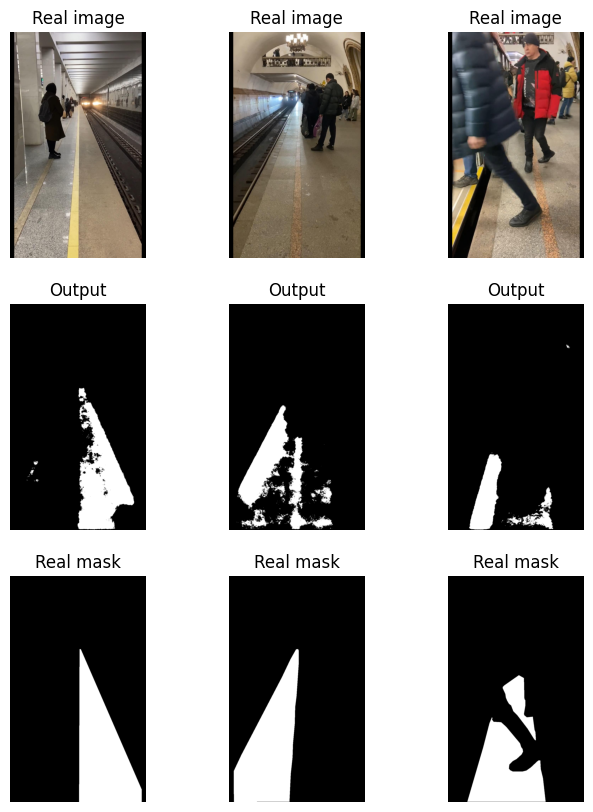


	Train loss: 0.36615598676144145;
	Val loss: 0.20399874087888747; 
	Val score: 0.13593750685686246;
* Epoch 2/20
Fit epoch time:  461.4318857192993
Eval epoch time:  18.61093807220459


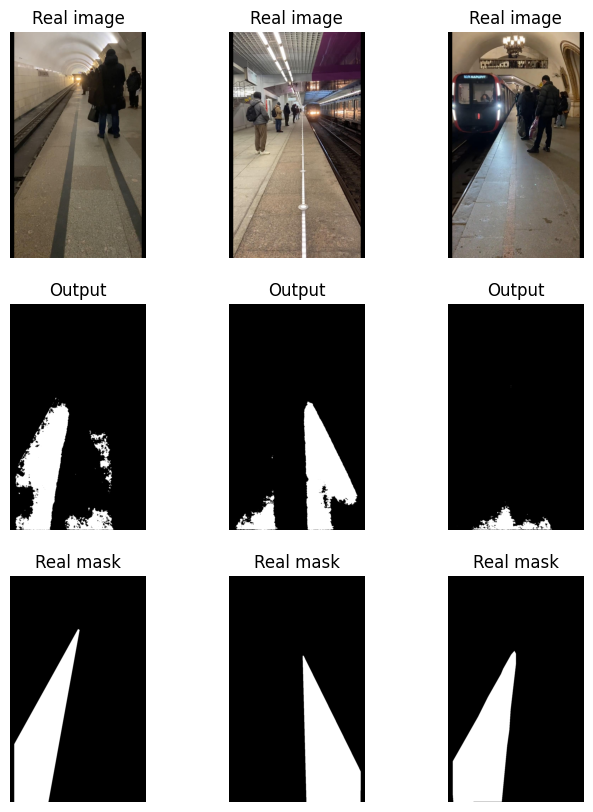


	Train loss: 0.17289959306071978;
	Val loss: 0.14904146152548492; 
	Val score: 0.30625001224689186;
* Epoch 3/20
Fit epoch time:  462.5924344062805
Eval epoch time:  18.587944507598877


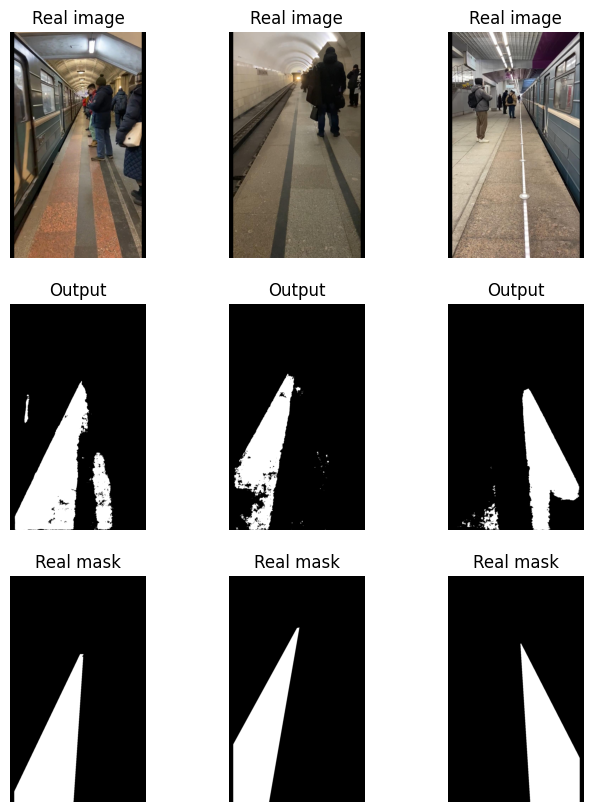


	Train loss: 0.13506295430852333;
	Val loss: 0.12271879310719669; 
	Val score: 0.37812501890584826;
* Epoch 4/20
Fit epoch time:  461.132292509079
Eval epoch time:  18.619937896728516


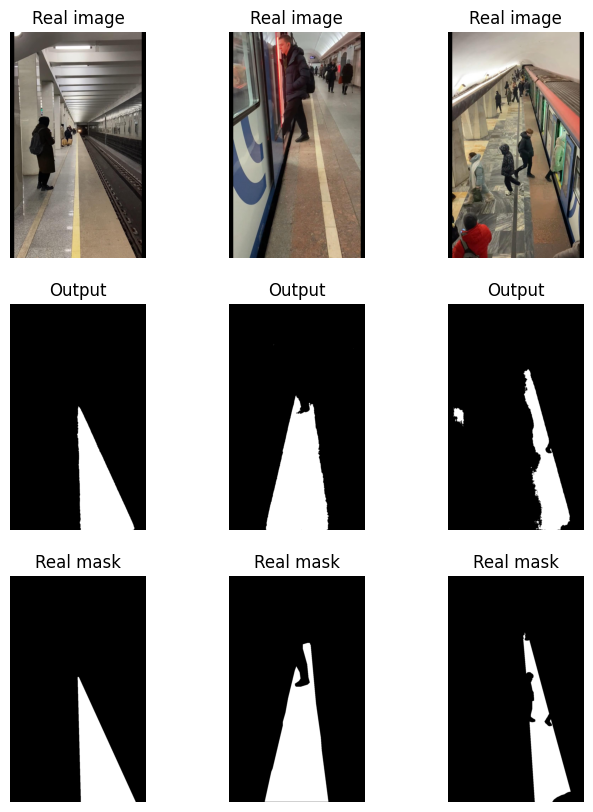


	Train loss: 0.10247592833911767;
	Val loss: 0.09374717058381066; 
	Val score: 0.5234375258442014;
* Epoch 5/20
Fit epoch time:  461.36866450309753
Eval epoch time:  18.610490798950195


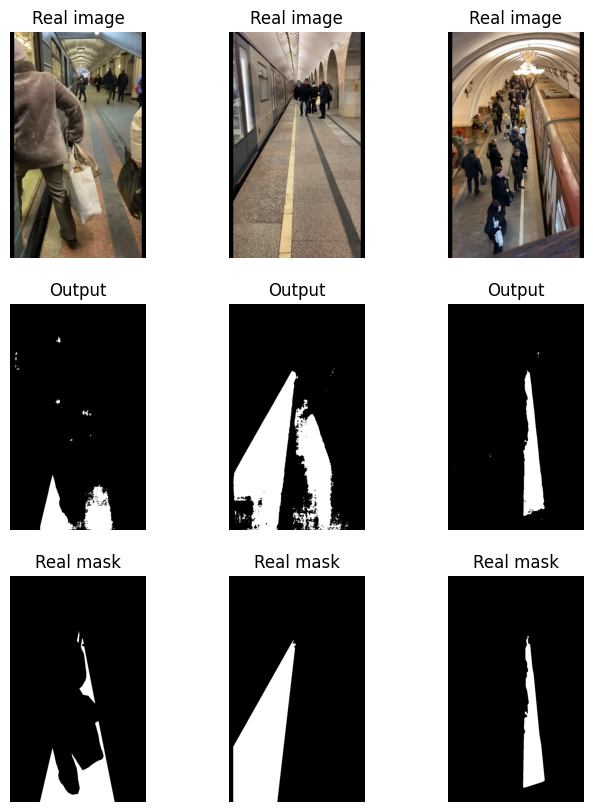


	Train loss: 0.09628067126323003;
	Val loss: 0.08931048261001706; 
	Val score: 0.5625000279396772;
* Epoch 6/20
Fit epoch time:  463.2081620693207
Eval epoch time:  18.67067265510559


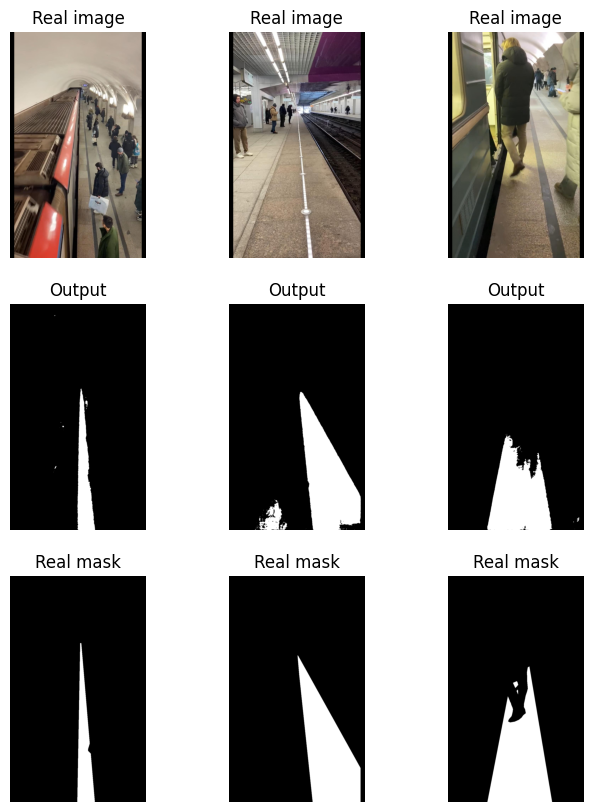


	Train loss: 0.0757187829221948;
	Val loss: 0.06731942226178944; 
	Val score: 0.6593750338070095;
* Epoch 7/20
Fit epoch time:  462.8278934955597
Eval epoch time:  18.76774549484253


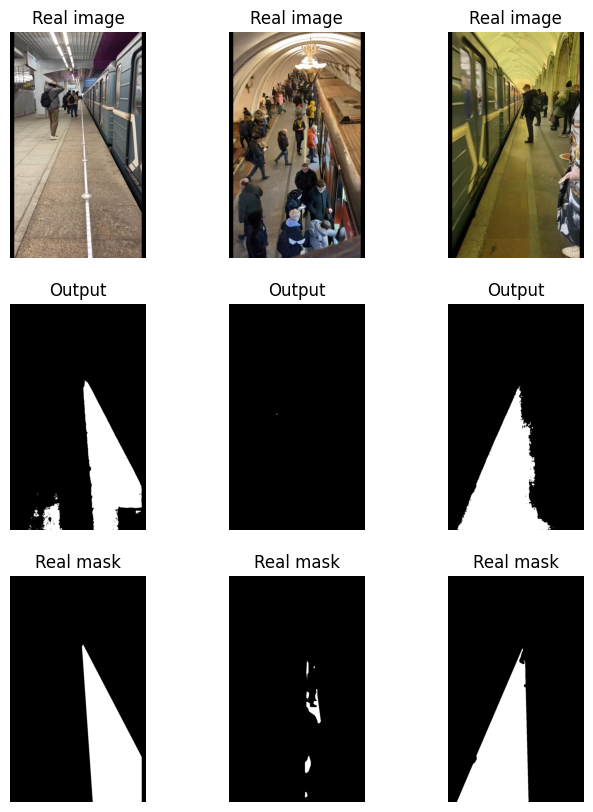


	Train loss: 0.06319604404779966;
	Val loss: 0.06765415446716361; 
	Val score: 0.631250036880374;
* Epoch 8/20
Fit epoch time:  462.5380437374115
Eval epoch time:  18.612226009368896


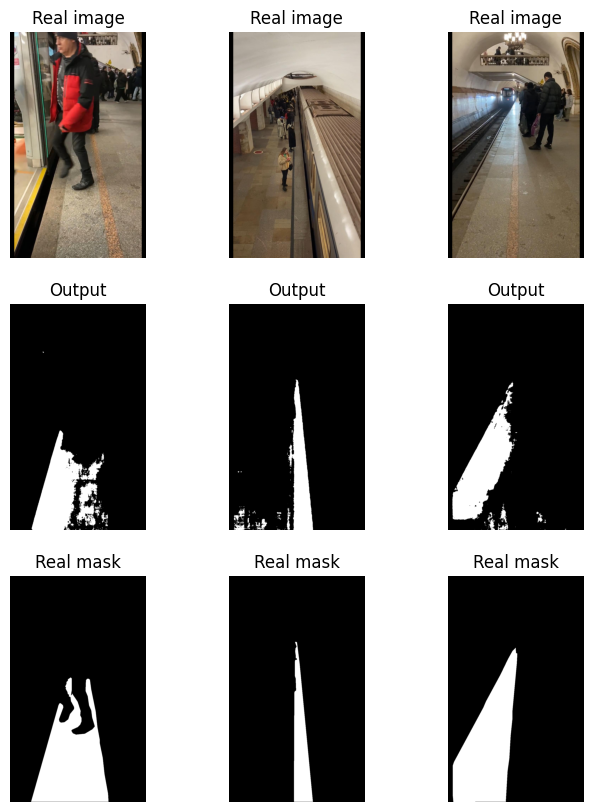


	Train loss: 0.06987503990603727;
	Val loss: 0.06268656914471649; 
	Val score: 0.6671875275205821;
* Epoch 9/20
Fit epoch time:  462.39220929145813
Eval epoch time:  18.57717204093933


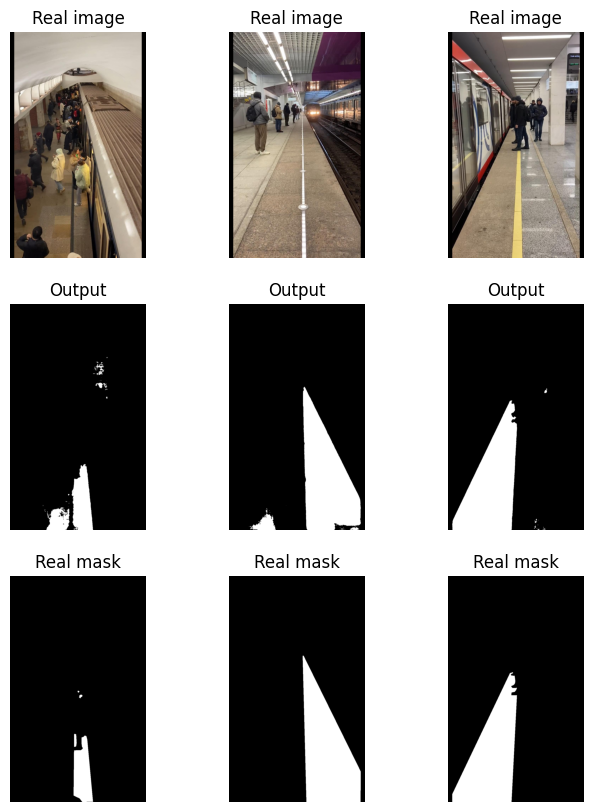


	Train loss: 0.04690561409370275;
	Val loss: 0.05474315577885136; 
	Val score: 0.7156250316184014;
* Epoch 10/20
Fit epoch time:  464.93210768699646
Eval epoch time:  18.864285707473755


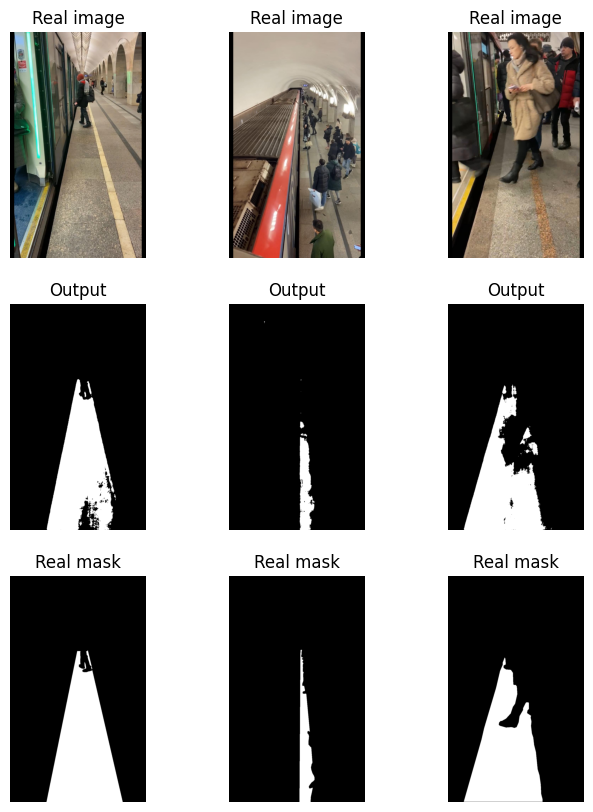


	Train loss: 0.04006377939185768;
	Val loss: 0.055281507840845734; 
	Val score: 0.7046875273808837;
* Epoch 11/20
Fit epoch time:  464.919025182724
Eval epoch time:  18.633399486541748


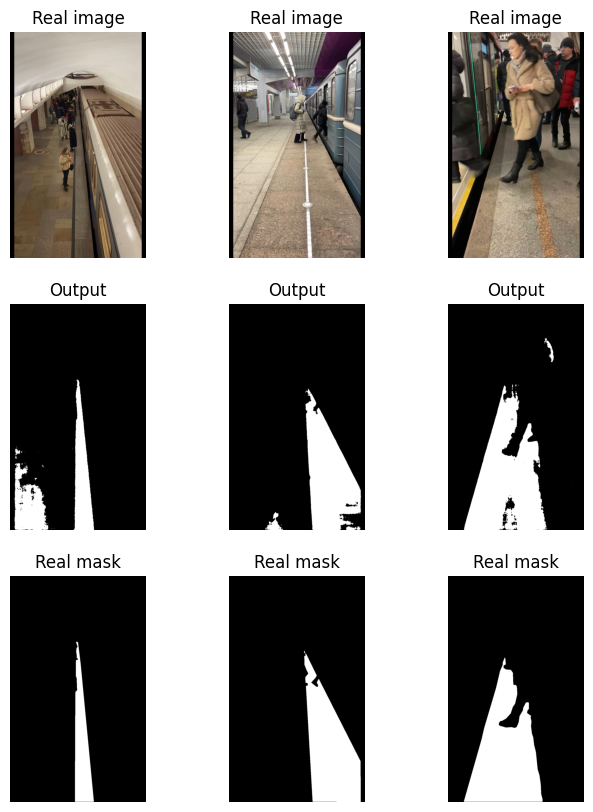


	Train loss: 0.044217749036761234;
	Val loss: 0.04819546587532386; 
	Val score: 0.751562534365803;
* Epoch 12/20
Fit epoch time:  461.81087470054626
Eval epoch time:  18.575438022613525


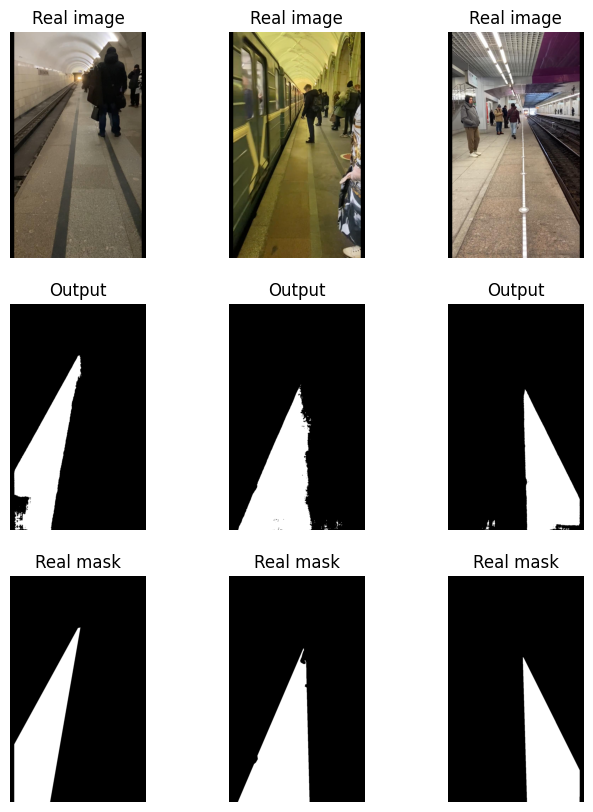


	Train loss: 0.0398106389966415;
	Val loss: 0.0462587249930948; 
	Val score: 0.7468750309199095;
* Epoch 13/20
Fit epoch time:  461.8978548049927
Eval epoch time:  18.592308521270752


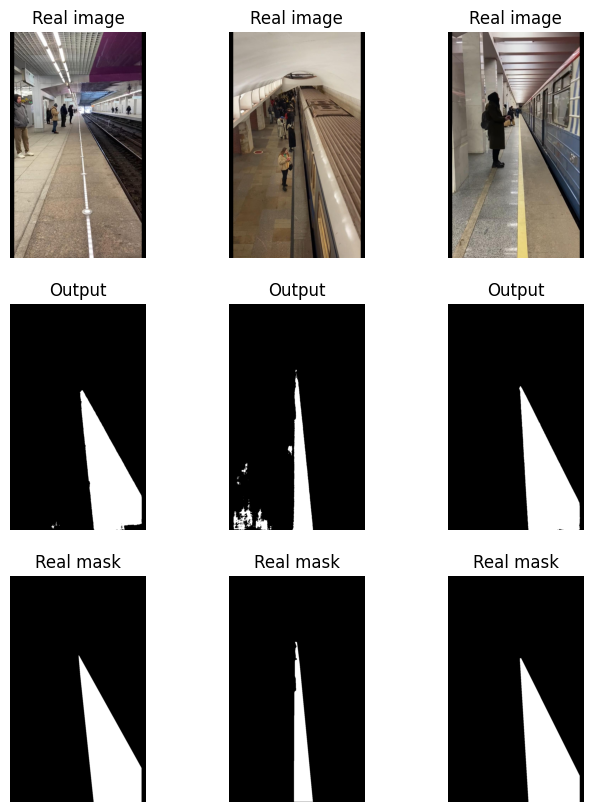


	Train loss: 0.032991384074193775;
	Val loss: 0.043402462208177894; 
	Val score: 0.785937528591603;
* Epoch 14/20
Fit epoch time:  462.15144753456116
Eval epoch time:  18.71262550354004


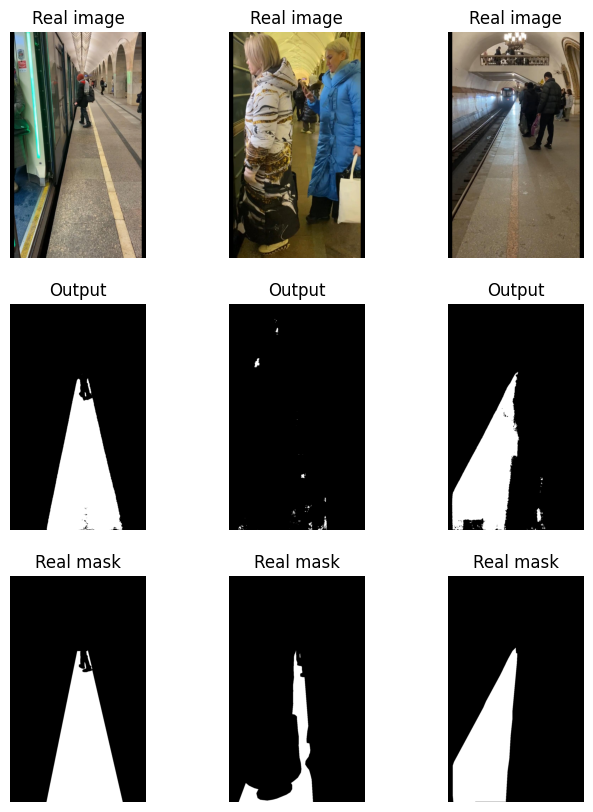


	Train loss: 0.0287097016498592;
	Val loss: 0.03885990289563779; 
	Val score: 0.7781250291736796;
* Epoch 15/20
Fit epoch time:  462.28668785095215
Eval epoch time:  18.64768075942993


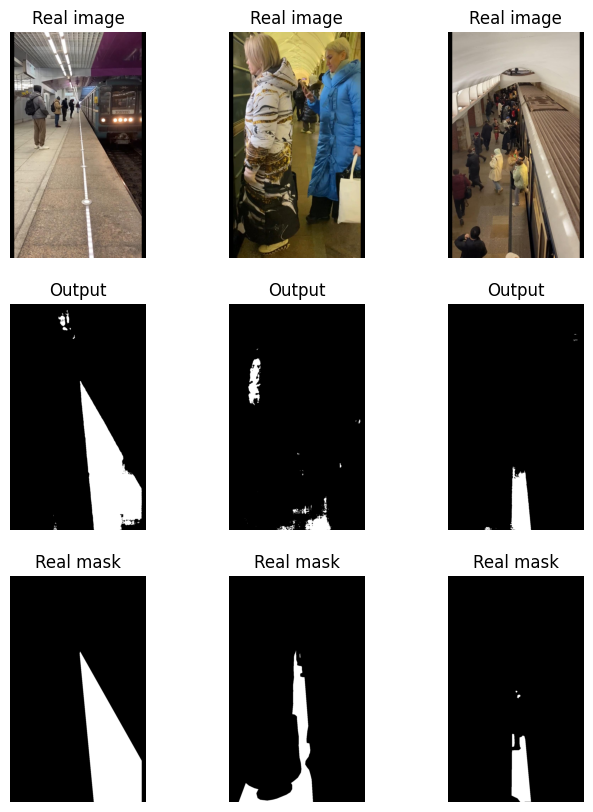


	Train loss: 0.023314795560509083;
	Val loss: 0.05222009166027419; 
	Val score: 0.7640625420026481;
* Epoch 16/20
Fit epoch time:  462.8626527786255
Eval epoch time:  18.675909996032715


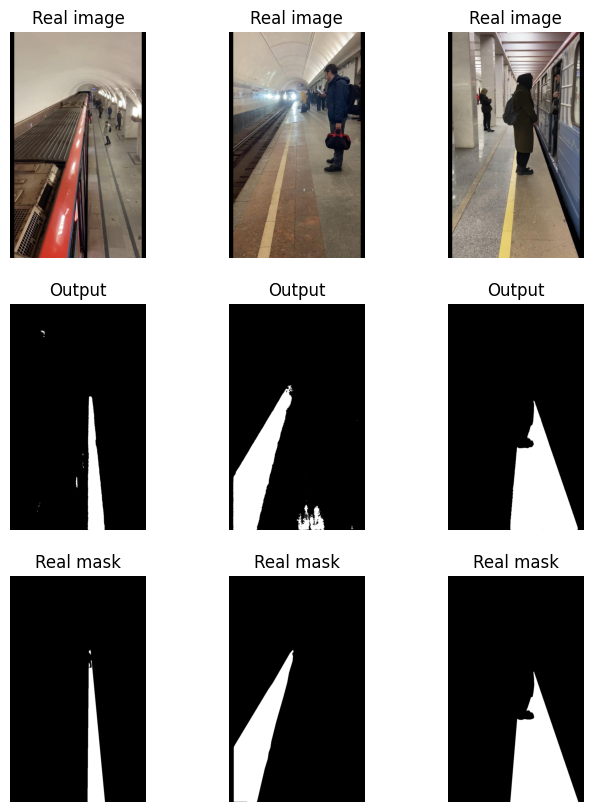


	Train loss: 0.04146110620331456;
	Val loss: 0.04389150507631712; 
	Val score: 0.7703125346451998;
* Epoch 17/20
Fit epoch time:  461.9982740879059
Eval epoch time:  18.607884168624878


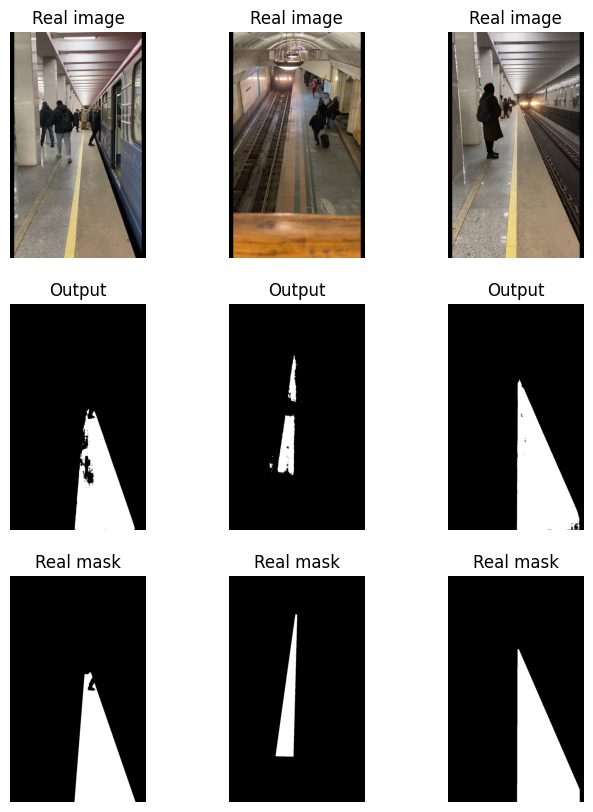


	Train loss: 0.026471943079741322;
	Val loss: 0.07502368665882386; 
	Val score: 0.6328125349245965;
* Epoch 18/20
Fit epoch time:  461.714478969574
Eval epoch time:  18.61650800704956


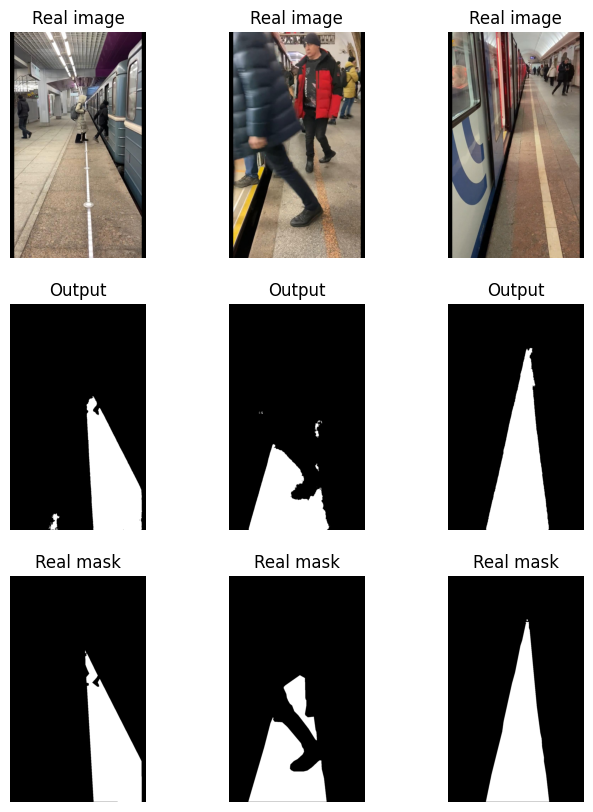


	Train loss: 0.024596849433692114;
	Val loss: 0.03508579745539464; 
	Val score: 0.8015625346451998;
* Epoch 19/20
Fit epoch time:  461.70310974121094
Eval epoch time:  18.740976810455322


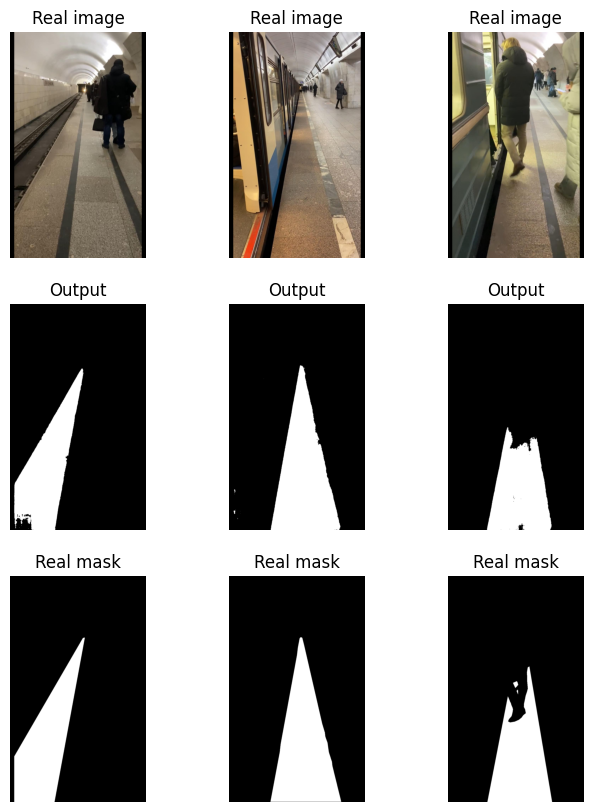


	Train loss: 0.01811084325890988;
	Val loss: 0.030284936699899845; 
	Val score: 0.8390625277534127;
* Epoch 20/20
Fit epoch time:  461.85916018486023
Eval epoch time:  18.721863508224487


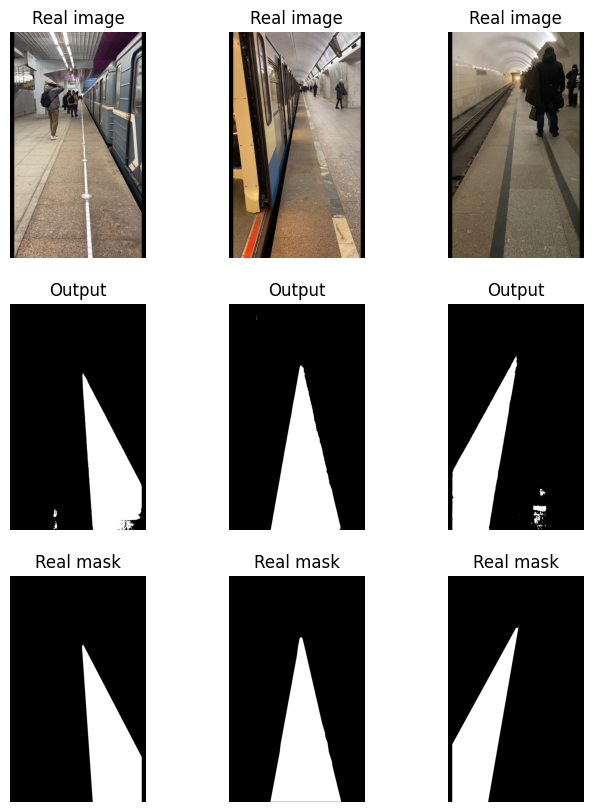


	Train loss: 0.014336310295220756;
	Val loss: 0.02622574799170252; 
	Val score: 0.8625000268220901;


In [ ]:
max_epochs = 20
optimizer = optim.Adam(segnet_model_bce.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, threshold=0.001, verbose=True)
loss_hist_1, score_hist_1 = train(segnet_model_bce, optimizer, bce_loss, max_epochs, data_tr, data_val, scheduler=scheduler)

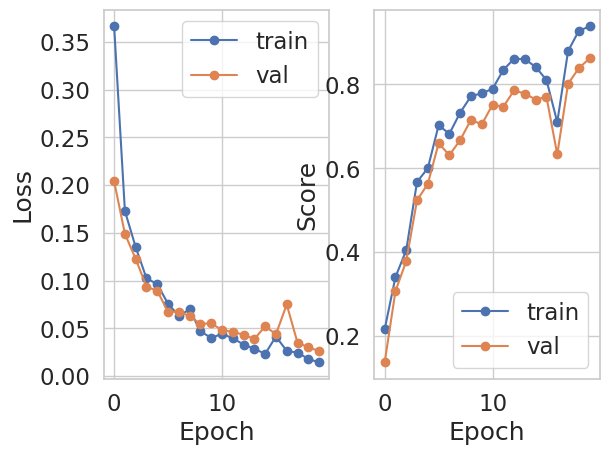

<Figure size 1200x600 with 0 Axes>

In [ ]:
analyze_history(np.array(loss_hist_1), np.array(score_hist_1))

In [16]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [18]:
segnet_model_bce = SegNet().to(device)
segnet_model_bce.load_state_dict(torch.load('/content/drive/MyDrive/segnet_bce_640_20_epoch.pth'))

<All keys matched successfully>

In [48]:
print(score_model(segnet_model_bce, iou_pytorch, data_val))

0.912500019185245


In [49]:
max_epochs = 10
optimizer = optim.Adam(segnet_model_bce.parameters(), lr=0.00001)

* Epoch 1/5
Fit epoch time:  483.8805658817291
Eval epoch time:  19.259474277496338


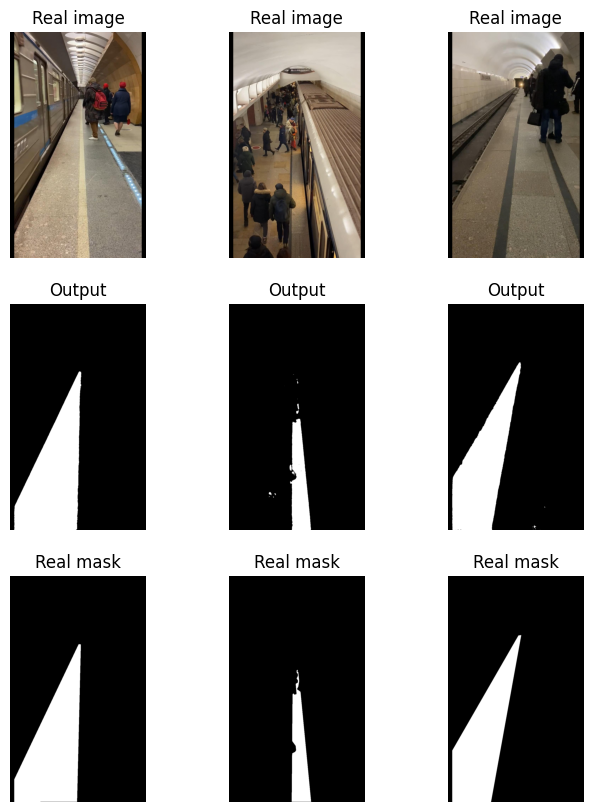


	Train loss: 0.012779903955561167;
	Val loss: 0.011143142957735108; 
	Val score: 0.917187511920929;
* Epoch 2/5
Fit epoch time:  479.0781943798065
Eval epoch time:  19.115185260772705


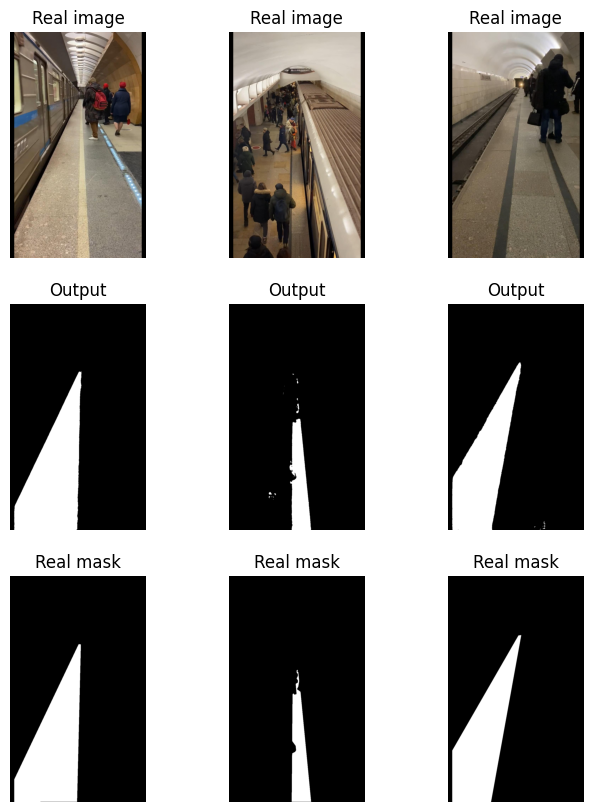


	Train loss: 0.01073780629576504;
	Val loss: 0.010052477075078059; 
	Val score: 0.9296875167638063;
* Epoch 3/5
Fit epoch time:  481.0123281478882
Eval epoch time:  19.173140048980713


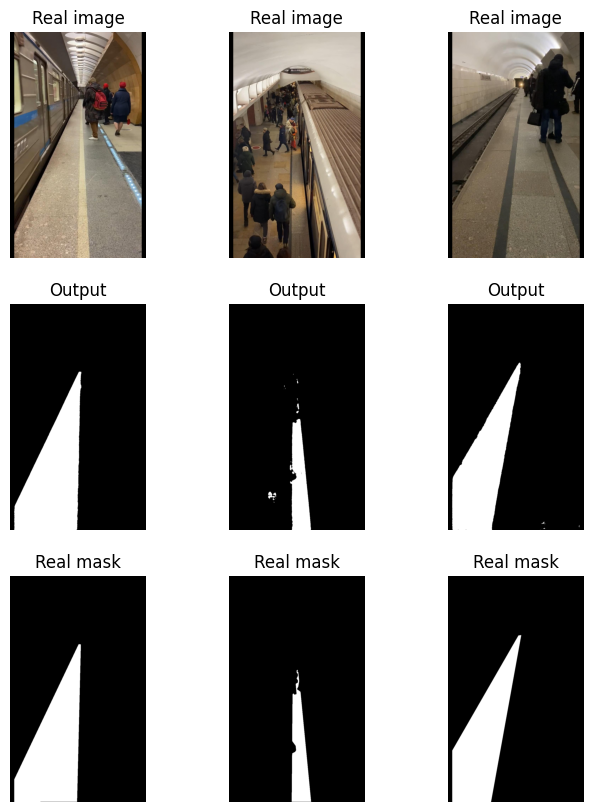


	Train loss: 0.01040068494148727;
	Val loss: 0.009939954645233229; 
	Val score: 0.9296875167638063;
* Epoch 4/5
Fit epoch time:  480.6896469593048
Eval epoch time:  19.214720010757446


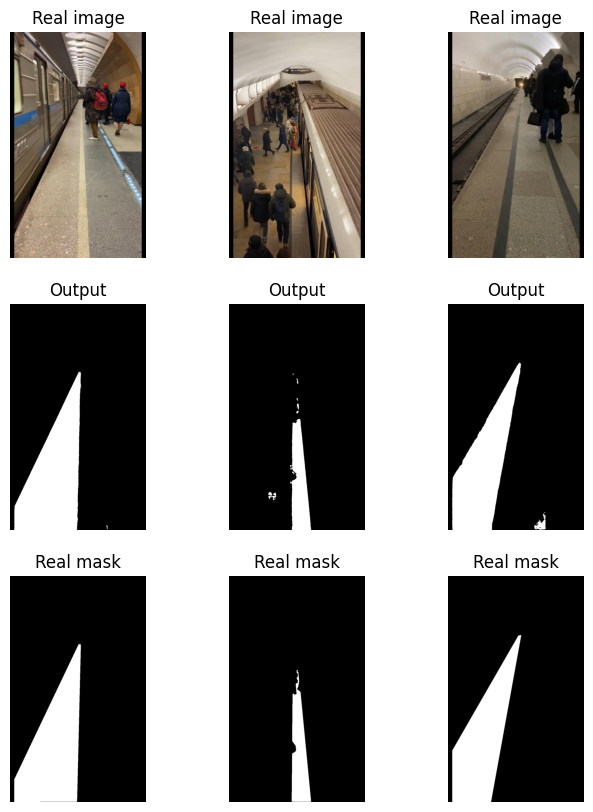


	Train loss: 0.009873690358290332;
	Val loss: 0.009998880075727357; 
	Val score: 0.9234375171363354;
* Epoch 5/5
Fit epoch time:  481.1857771873474
Eval epoch time:  19.286141633987427


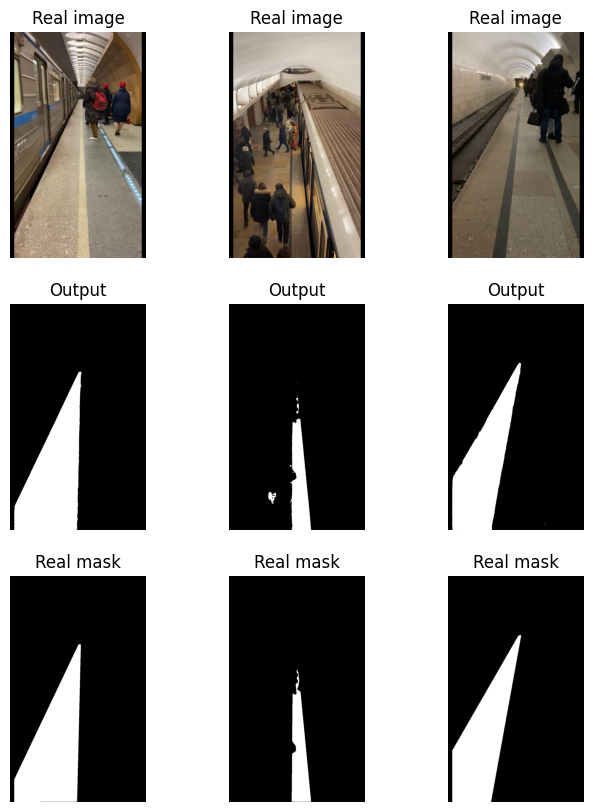


	Train loss: 0.009353265309982817;
	Val loss: 0.009867470878816675; 
	Val score: 0.9281250154599547;


In [51]:
loss_hist_2, score_hist_2 = train(segnet_model_bce, optimizer, bce_loss, 5, data_tr, data_val)

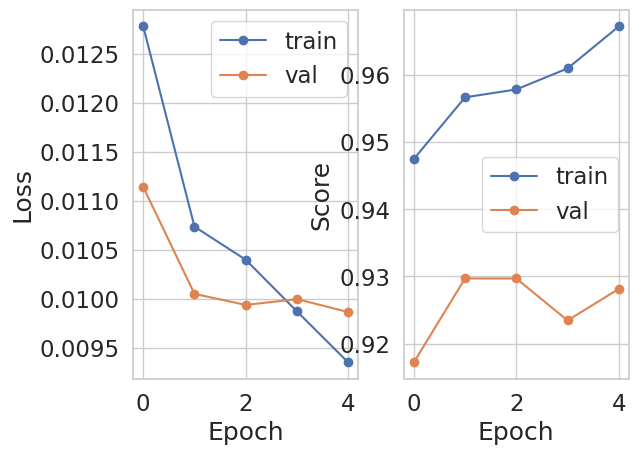

<Figure size 1200x600 with 0 Axes>

In [52]:
analyze_history(np.array(loss_hist_2), np.array(score_hist_2))

In [ ]:
loss_hist_3, score_hist_3 = train(segnet_model_bce, optimizer, bce_loss, 5, data_tr, data_val)

* Epoch 1/5


In [ ]:
analyze_history(np.array(loss_hist_3), np.array(score_hist_3))